This notebook demonstrates how to use `pretrained-microscopy-models` to perform binary segmentation on environmental barrier coating data. This is the EBC-1 dataset in the accompanying paper.

In [1]:
import os
import torch
import cv2
import random
import imageio

import numpy as np
import matplotlib.pyplot as plt
import pretrained_microscopy_models as pmm
import segmentation_models_pytorch as smp
import albumentations as albu

from pathlib import Path
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [2]:
# set random seeds for repeatability
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

## ML Model

In [3]:
# model parameters
architecture = 'UnetPlusPlus'
encoder = 'se_resnext50_32x4d'
pretrained_weights = 'micronet'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create the UnetPlusPlus model with a se_resnext50_32x4d backbone 
# that is pre-trained on micronet
model = pmm.segmentation_training.create_segmentation_model(
    architecture=architecture,
    encoder = encoder,
    encoder_weights=pretrained_weights, # use encoder pre-trained on micronet
    classes=1 # Set 1 for binary classification (the background class is implicit)
    )

## Dataset

Note that the example annotations appear black because the pixel values are
0, 1, and 2 out of 255.

In [4]:
DATA_DIR = 'EBC1'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_annot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_annot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_annot')

#### Image Augmentation
Adding noise, contrast, random crops, flipping and other image augmentations can artifically augment the training dataset and make the model more robust to changes in these conditions

In [5]:
def get_training_augmentation(prob=0.3, power=1):
    """Need to make sure image shape is divisible by 32"""
    train_transform = [
        albu.HorizontalFlip(p=0.5), #only horizontal to preserve orientation
        albu.RandomCrop(512, 512),
        albu.GaussNoise(p=0.5),
        albu.RandomBrightnessContrast(p=0.3),

        albu.OneOf(
            [
                albu.Sharpen(p=1, alpha=(0.2, 0.5*power)),
                albu.Blur(blur_limit=3*power, p=1),
            ],
            p=0.3,
        ),
        
    ]

    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Need to make sure image shape is divisible by 32"""
    test_transform = [
        # instead of center cropping we will crop a little lower in the 
        # validation data to more accurately capture where the oxide layer is.
        albu.Crop(256, 256+100, 768, 768+100)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

### Create datasets

In [6]:
# how the images will be normalized. Use imagenet statistics even on micronet pre-training
preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder, 'imagenet') 

# pixel values of the annotations for each mask.
# Note: for binary classification we only need to specify the forground class
# Note 2: you can specify multiple annotation values for the same class
#       (in this case the oxide cracks are also annotated, but not used in this example)
class_values = {'oxide': [1,2]}


# For multiclass segmentation we can pass the directory for images and masks.
# because they follow the naming convention "image1.tif" and "image1_mask.tif"
# in this case we need to pass the list of image and annotation paths explicitly
# because the annotation data does not follow that naming convention
train_images = [os.path.join(x_train_dir, image_id) for image_id in os.listdir(x_train_dir)]
train_masks = [os.path.join(y_train_dir, image_id) for image_id in os.listdir(y_train_dir)]

valid_images = [os.path.join(x_valid_dir, image_id) for image_id in os.listdir(x_valid_dir)]
valid_masks = [os.path.join(y_valid_dir, image_id) for image_id in os.listdir(y_valid_dir)]

test_images = [os.path.join(x_test_dir, image_id) for image_id in os.listdir(x_test_dir)]
test_masks = [os.path.join(y_test_dir, image_id) for image_id in os.listdir(y_test_dir)]


training_dataset = pmm.io.Dataset(
    images=train_images,
    masks=train_masks,
    class_values=class_values,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)

validation_dataset = pmm.io.Dataset(
    images=valid_images,
    masks=valid_masks,
    class_values=class_values,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)

test_dataset = pmm.io.Dataset(
    images=test_images,
    masks=test_masks,
    class_values=class_values,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)

### Visualize datasets

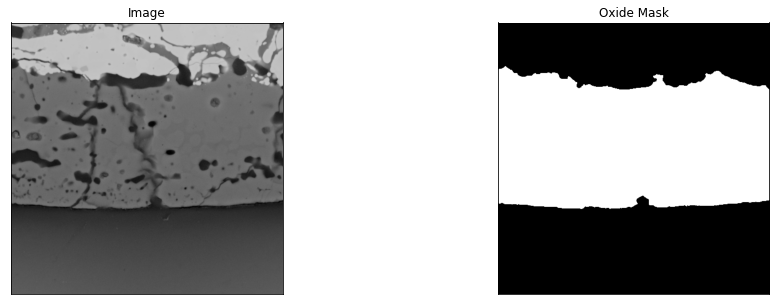

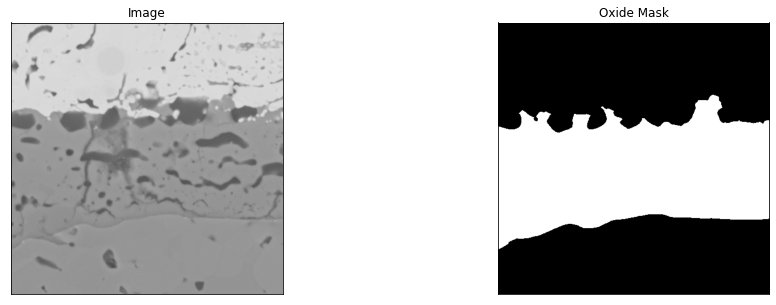

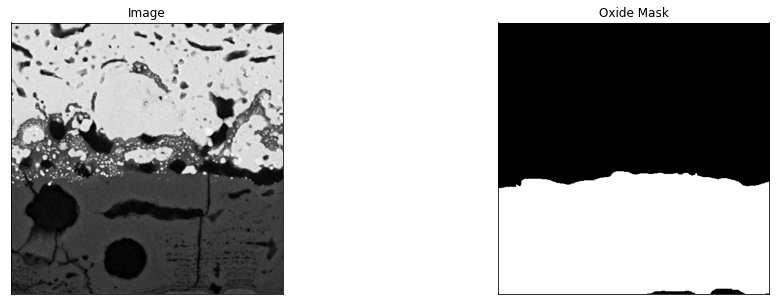

In [7]:
### validation data

# we need to remove pre_processing to see the data
visualize_dataset = pmm.io.Dataset(
    images=valid_images,
    masks=valid_masks,
    class_values=class_values,
    augmentation=get_validation_augmentation(),
)

for im, mask in visualize_dataset:
    pmm.util.visualize(
        image=im,
        oxide_mask=mask.squeeze(),
    )


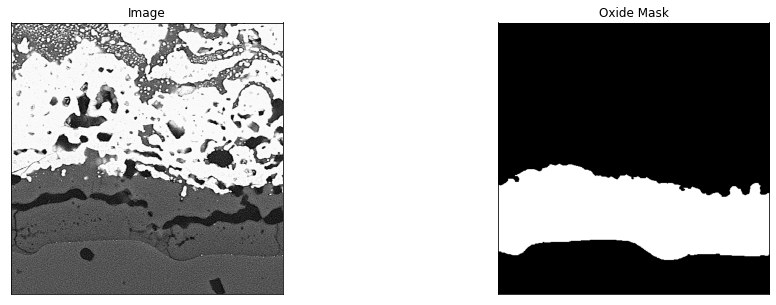

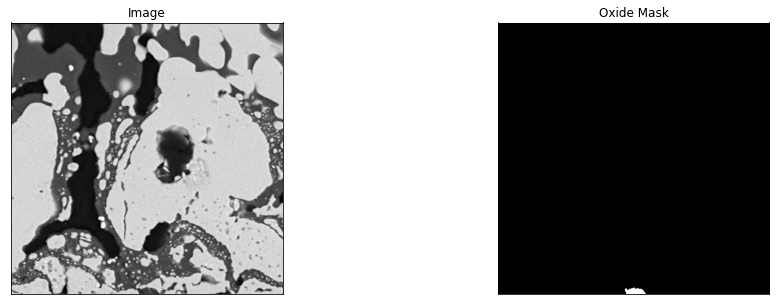

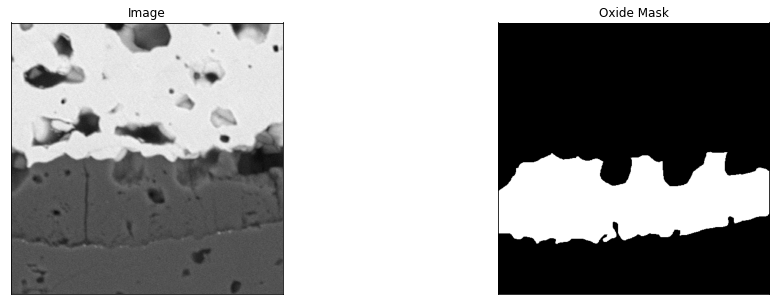

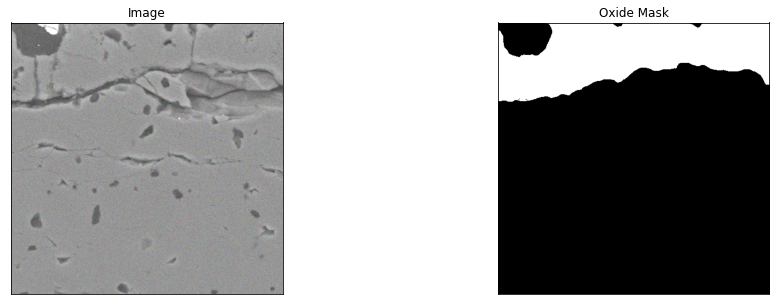

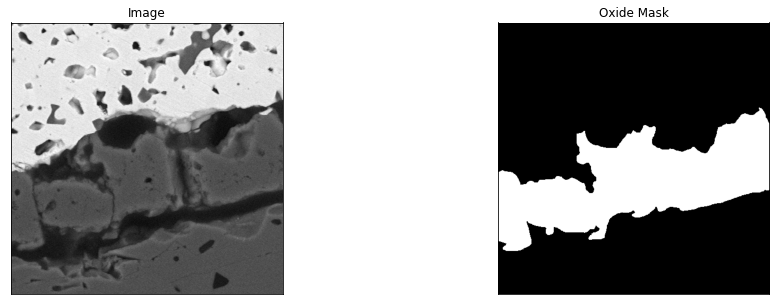

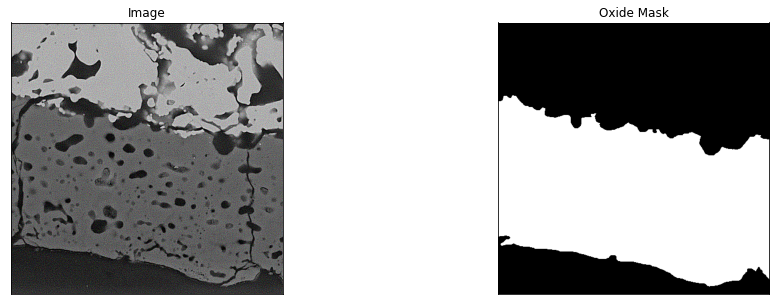

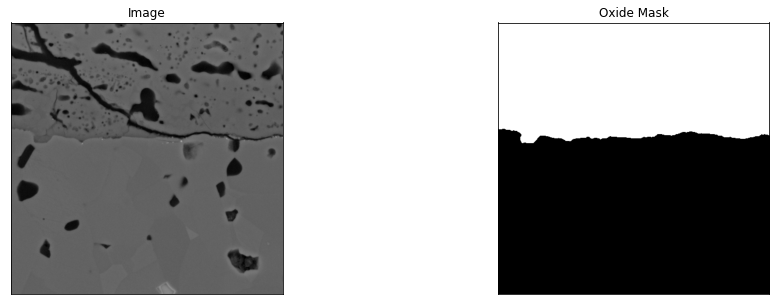

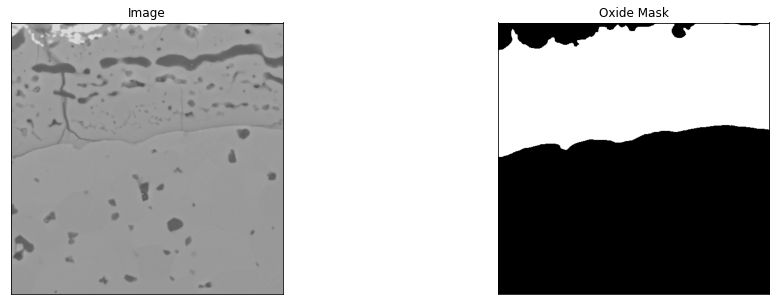

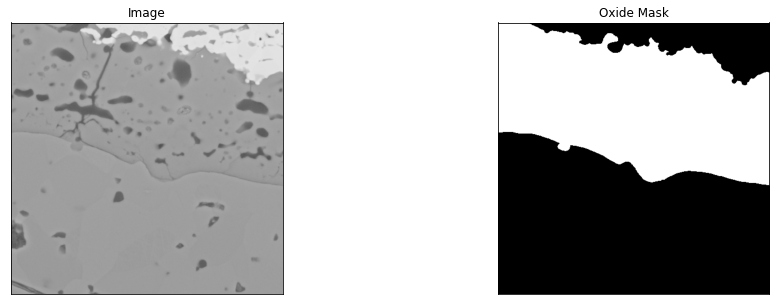

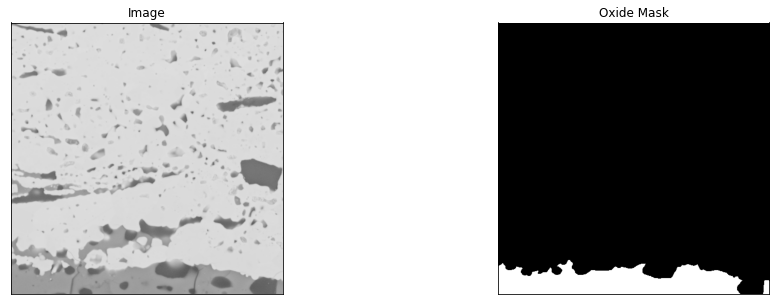

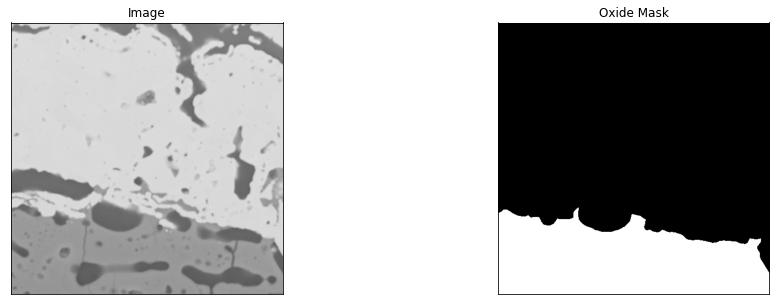

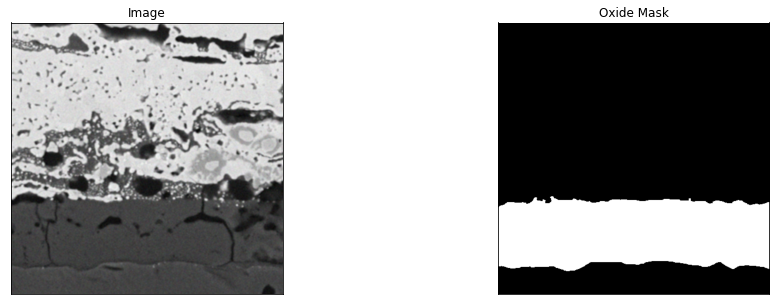

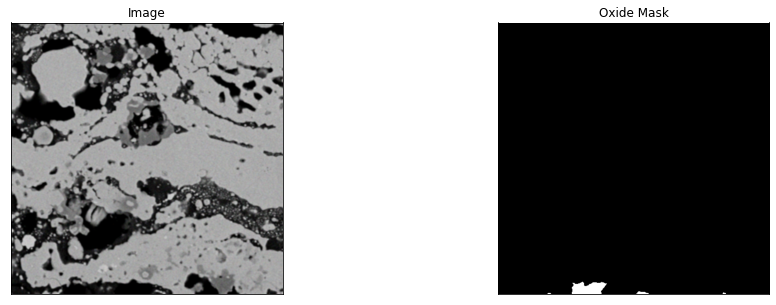

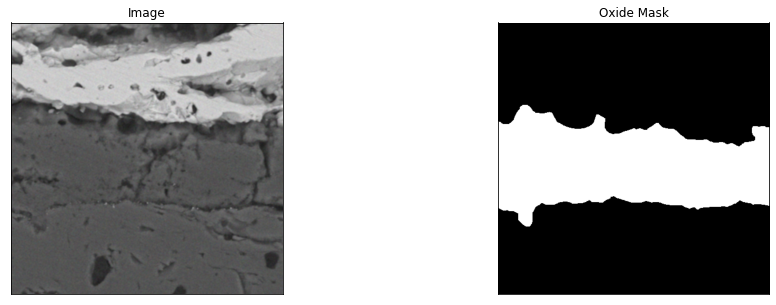

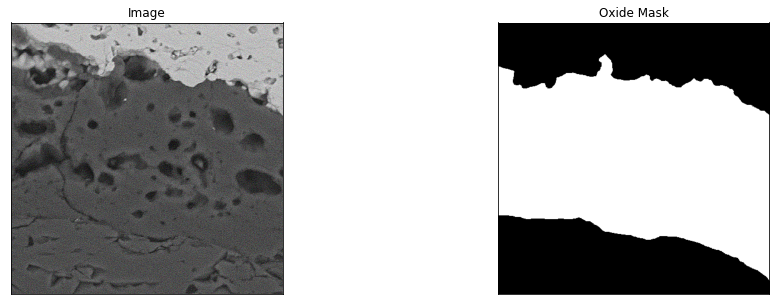

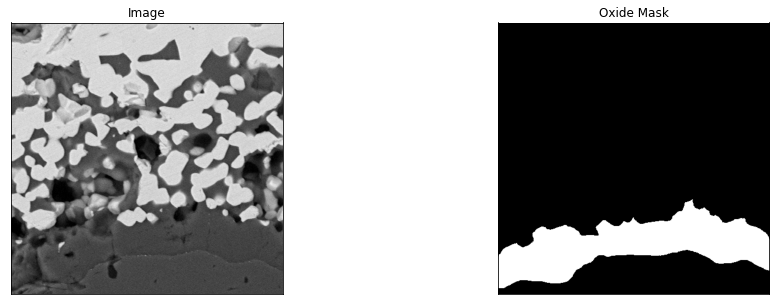

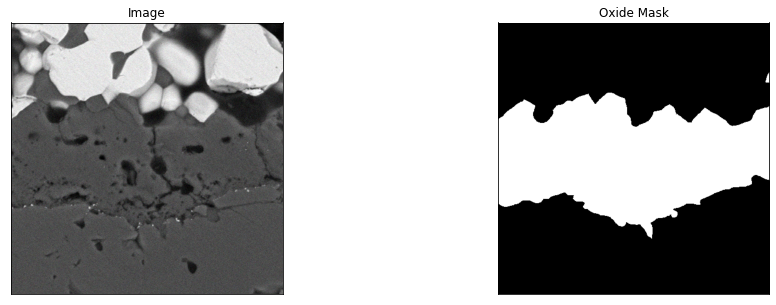

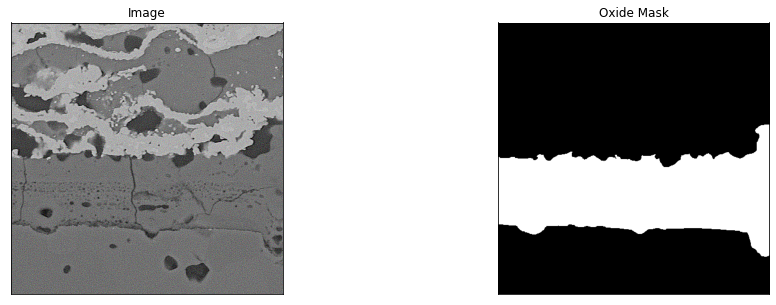

In [8]:
### training data

# we need to remove pre_processing to see the data
visualize_dataset = pmm.io.Dataset(
    images=train_images,
    masks=train_masks,
    class_values=class_values,
    augmentation=get_training_augmentation(),
)

for im, mask in visualize_dataset:
    pmm.util.visualize(
        image=im,
        oxide_mask=mask.squeeze(),
    )


## Train ML Model

In [9]:
state = pmm.segmentation_training.train_segmentation_model(
    model=model,
    architecture=architecture,
    encoder=encoder,
    train_dataset=training_dataset,
    validation_dataset=validation_dataset,
    class_values=class_values,
    patience=30,
    lr=2e-4,
    batch_size=6,
    val_batch_size=6,
    save_folder='models',
    save_name='binary_segmentation_example.pth.tar'
)


Epoch: 0, lr: 0.00020000, time: 0.00 seconds, patience step: 0, best iou: 0.0000
train:   0%|          | 0/3 [00:00<?, ?it/s]


ValueError: axes don't match array

In [18]:
print(class_values[list(class_values.keys())[0]])

[1, 2]
